# Introduction à dask grâce aux données DVF

Pour essayer les exemples présents dans ce tutoriel :

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/07_dask.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/07_dask.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/07_dask.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABmanipulation%2007_dask%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=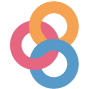" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/07_dask.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/manipulation/07_dask.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

La documentation complète sur `Dask` se trouve sur <https://docs.dask.org/>.

Le projet requiert l’installation de `dask`. Afin d’avoir
la distribution complète on utilise la commande suivante:

``` shell
pip install dask[complete]
```

# Pourquoi utiliser `Dask` ?

On peut se référer à la page https://docs.dask.org/en/stable/why.html

Plusieurs points sont mis en avant dans la documentation officielle et sont résumés ci-dessous:
- `Dask` ressemble fortement en termes de syntaxe à `pandas` et `numpy` ;
- `Dask` peut être utilisé sur un ordinateur seul ou sur un *cloud cluster*. Avec `Dask`, on peut traiter des bases de 100GB sur un ordinateur portable, voire même 1TB sans même avoir besoin d’un cluster *big data* ;
- `Dask` requiert peu de temps d’installation puisqu’il peut être installé avec le gestionnaire de *packages* `conda` (il est même livré dans la distribution par défaut d’Anaconda)

## Comment `Dask` se compare à `Spark` ?

Dans le monde du *big-data*, un écosystème concurrent existe: [`Spark`](https://spark.apache.org/). Globalement, lorsqu’on a compris la logique
de l’un, il est très facile de faire la transition vers l’autre si besoin<a name="cite_ref-1"></a>[<sup>\[1\]</sup>](#cite_note-1). Pour ma part, j’ai principalement fait du `Spark` sur
des [données de téléphonie de plusieurs TB](https://www.linogaliana.fr/publication/2020-segregation/). En fait, la logique sera la même que celle de `Dask` sur données moins volumineuses.

Sauf si on doit mettre en oeuvre soi-même l’infrastructure `Spark`, ce qui relève plus des compétences du *data architect* que du *data scientist*.

-   `Spark` est écrit en `Scala` à l’origine. Le package [`pyspark`](https://spark.apache.org/docs/latest/api/python/) permet d’écrire en `Python` et s’assure de la traduction en `Python` afin d’interagir avec les machines virtuelles `Java` (JVM) nécessaires pour la parallélisation des opérations `Spark`. `Dask` est quant à lui écrit en Python, ce qui est un écosystème plus léger. Pour gagner en performance, il permet d’interagir avec du code C/C++ entre autres ;
-   L’installation de `Spark` est plus lourde que celle de `Dask`
-   `Spark` est un projet Apache en lui-même alors que `Dask` intervient comme une composante de l’univers `Python`;
-   `Spark` est un peu plus vieux (2010 versus 2014 pour `Dask`) ;
-   `Spark` permet de très bien faire des opérations classiques SQL et des ETLs, et proposer ses propres librairies de parallélisation de modèles de *machine learning*. Pour faire du *machine learning* avec `Spark` il faut aller piocher dans `Spark MLLib`. `Dask` permet quant à lui de bien interagir avec `scikit-learn` et de faire de la modélisation.

Globalement, il faut retenir que `Dask` comme `Spark` ne sont intéressants que pour des données dont le traitement engendre des problèmes de RAM. Autrement, il
vaut mieux se contenter de `pandas`.

# Démonstration de quelques *features* de `Dask`

## Présentation du `Dask.DataFrame`

Nous allons utiliser les [données immobilières `DVF`](https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres/) pour montrer quelques éléments clefs de `Dask`.

In [2]:
# Import dvf files 
import pandas as pd
import dask.dataframe as dd

d_urls = {
    "2019" : 'https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2',
    "2020" : "https://www.data.gouv.fr/fr/datasets/r/90a98de0-f562-4328-aa16-fe0dd1dca60f",
    "2021": "https://www.data.gouv.fr/fr/datasets/r/817204ac-2202-4b4a-98e7-4184d154d98c"
}


def import_dvf_one_year(year, dict_url = d_urls):
    df = pd.read_csv(dict_url[year], sep = "|", decimal=",")
    df["year"] = year
    return df

def import_dvf_all_years(dict_url = d_urls):
    dfs = [import_dvf_one_year(y, dict_url) for y in dict_url.keys()]
    df = pd.concat(dfs).reset_index()
    df = df.drop(["level_0", "level_1"], axis=1)
    return df

Dans un premier temps, on va utiliser `pandas` pour
importer une année de données (millésime 2019), ces dernières tenant en mémoire
sur un ordinateur normalement doté en RAM`{=html} <a name="cite_note-1"></a>1. [^](#cite_ref-1)`

In [3]:
dvf = import_dvf_one_year("2019")
dvf.shape
dvf.head()

/tmp/ipykernel_679/455432909.py:13: DtypeWarning:

Columns (14,18,23,24,26,28,41) have mixed types. Specify dtype option on import or set low_memory=False.


,Code service sages,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2019,Vente,...,1,2.0,Appartement,NaN,20.0,1.0,NaN,NaN,NaN,2019
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2019,Vente,...,1,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN,2019
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2019,Vente,...,2,2.0,Appartement,NaN,62.0,3.0,NaN,NaN,NaN,2019
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,08/01/2019,Vente,...,0,1.0,Maison,NaN,90.0,4.0,S,NaN,940.0,2019
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,07/01/2019,Vente,...,0,1.0,Maison,NaN,101.0,5.0,S,NaN,490.0,2019


Ce site web est testé sur les serveurs d’intégration
continue mis à disposition gratuitement par `Github`. Ces
derniers sont des machines à la mémoire limitée. Il s’agit
d’un bon exemple d’intérêt de `dask`: avec `pandas`, on ne
peut tester les exemples sur les trois millésimes disponibles
car la volumétrie accède la RAM disponible.

Ici on travaille sur un `DataFrame` d’environ 3.5 millions de lignes et 44 variables.
L’objet `dvf` est un `pandas.DataFrame`
qui tient en mémoire sur le `SSP-Cloud` ou sur les serveurs utilisés
pour construire ce site web.

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 1</h3>

On aurait pu lire directement les csv dans un `dask.DataFrame` avec le `read_csv` de `dask`. Comme exercice, vous pouvez essayer de le faire
pour une année (analogue de la fonction `import_dvf_one_year`) puis sur toutes les données (analogue de la fonction `import_dvf_all_years`).

</div>

On peut créer une structure `Dask` directement à partir
d’un `DataFrame` `pandas` avec la méthode `from_pandas`.

In [4]:
dvf_dd = dd.from_pandas(dvf, npartitions=10) 
dvf_dd

,Code service sages,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Prefixe de section,Section,No plan,No Volume,1er lot,Surface Carrez du 1er lot,2eme lot,Surface Carrez du 2eme lot,3eme lot,Surface Carrez du 3eme lot,4eme lot,Surface Carrez du 4eme lot,5eme lot,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,year
npartitions=10,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,float64,float64,int64,object,object,float64,float64,object,object,object,object,float64,object,object,int64,float64,object,int64,object,object,float64,object,float64,object,float64,float64,float64,float64,float64,int64,float64,object,float64,float64,float64,object,object,float64,object
362396,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261562,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3623956,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Pour souligner la différence avec un `pandas.DataFrame`,
l’affichage diffère. Seule la structure du `dask.DataFrame`
est affichée et non son contenu car les données
`dask` ne sont pas chargées en mémoire.

<div class="alert alert-danger" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left: .2rem solid #ff0039;">
<i class="fa fa-exclamation-triangle"></i> Warning</h3>

Attention, `Dask` ne peut créer un `Dask.DataFrame` à partir d’un `pandas.DataFrame` multi-indexé.

Dans ce cas il a fallu faire un `reset_index()` pour avoir un unique index.

</div>

On a ainsi la structure de notre `dask.DataFrame`, soit environ 3.5 millions de lignes, avec 44 colonnes en 10 partitions, soit environ 350 000 observations par partition.

Il faut savoir que `Dask` produit des `Array`, `Bag` et `DataFrames`, qui fonctionnent comme dans `Numpy` et `Pandas` (il est possible de créer d’autres structures *ad hoc*, cf plus loin).
`Dask`, comme `Spark` et en fait comme la plupart des *frameworks* permettant de
traiter des données plus volumineuses que la RAM disponible,
repose sur le principe du partitionnement et de la parallélisation
des opérations. Les données ne sont jamais importées dans leur
ensemble mais par bloc. Un plan des opérations à effectuer est
ensuite appliquer sur chaque bloc (nous reviendrons
sur ce principe), indépendamment. La particularité de `Dask`,
par rapport à `Spark`,
est que chaque bloc est un `pandas.DataFrame`, ce qui
rend très facile l’application de manipulations de données
traditionnelles sur des sources volumineuses:

![](https://docs.dask.org/en/stable/_images/dask-dataframe.svg)

Le site de `Dask` cite une règle qui est la suivante :

> *“Have 5 to 10 times as much RAM as the size of your dataset”*,
>
> @mckinney2017apache, [*10 things I hate about pandas*](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)

Sur disque, en sauvegardant en `CSV`, on
obtient une base de 1.4GB. Si l’on suit la règle du pouce donnée plus haut, on va avoir besoin d’une RAM entre 7-14GB pour traiter la donnée, en fonction de nos traitements qui seront plus ou moins intensifs. Autrement dit, si on a moins de 8GB de RAM, il devient intéressant de faire appel à `dask`, sinon il vaut mieux privilégier `pandas` (sauf si on fait des
traitements très intensifs en calculs).

Il existe un autre objet `dask`, les `Array` pour reprendre la logique de `numpy`. De la même manière qu’un `dask.DataFrame` est en quelque sorte un ensemble de `pandas.DataFrame`, un `dask.Array` est un ensemble de `numpy.Array` qui sont plus importants en taille que la RAM. On pourra utiliser les opérations courantes `numpy` avec `dask` de la même manière que le `dask DataFrame` réplique la logique du `pandas DataFrame`.

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-lightbulb-o"></i> Hint</h3>

Le choix du nombre de partition (10) est arbitraire ici. Bien qu’on puisse
trouver des règles du pouce pour fixer un nombre optimal de
partitions, cela dépend de beaucoup de facteurs et, en pratique,
rien ne remplace l’essai-erreur. Par exemple, [la documentation `Dask` recommande des blocs d’environ
100MB](https://docs.dask.org/en/stable/dataframe-best-practices.html)
ce qui peut convenir pour des ordinateurs à la RAM limitée mais n’a pas
forcément de sens pour des machines ayant 16GB de RAM.
Un nombre important de partition va permettre de faire des opérations
sur des petits blocs de données, ce qui permettra de gagner en vitesse
d’exécution. Le prix à payer est beaucoup *d’input/output* car
`Dask` va passer du temps à lire beaucoup de blocs de données et écrire
des bases intermédiaires.

</div>

On peut accéder aux index que couvrent les partitions de la manière suivante:

In [5]:
dvf_dd.divisions

(0,
 362396,
 724792,
 1087188,
 1449584,
 1811980,
 2174376,
 2536772,
 2899167,
 3261562,
 3623956)

Autrement dit, la première partition couvrira les lignes 0 à 362396. La deuxième les lignes 362397 à 724792, etc.

Et on peut directement accéder à une partition grâce aux crochets `[]`:

In [7]:
dvf_dd.partitions[0]

,Code service sages,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Prefixe de section,Section,No plan,No Volume,1er lot,Surface Carrez du 1er lot,2eme lot,Surface Carrez du 2eme lot,3eme lot,Surface Carrez du 3eme lot,4eme lot,Surface Carrez du 4eme lot,5eme lot,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,year
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,float64,float64,int64,object,object,float64,float64,object,object,object,object,float64,object,object,int64,float64,object,int64,object,object,float64,object,float64,object,float64,float64,float64,float64,float64,int64,float64,object,float64,float64,float64,object,object,float64,object
362396,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## La *“lazy evaluation”*

`Dask` fait de la **“lazy evaluation”**. Cela signifie que le résultat n’est calculé que si on le demande explicitement. Dans le cas, contraire, ce que l’on appelle un `dask` **task graph** est produit (on verra plus bas comment voir ce *graph*).

Pour demander explicitement le résultat d’un calcul, il faut utiliser la
méthode `compute`.
A noter que certaines méthodes vont déclencher un `compute` directement, comme par exemple `len` ou `head`.

Par exemple, pour afficher le contenu des 100 premières lignes :

In [8]:
dvf_dd.loc[0:100,:].compute()

,Code service sages,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2019,Vente,...,1,2.0,Appartement,NaN,20.0,1.0,NaN,NaN,NaN,2019
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2019,Vente,...,1,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN,2019
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2019,Vente,...,2,2.0,Appartement,NaN,62.0,3.0,NaN,NaN,NaN,2019
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,08/01/2019,Vente,...,0,1.0,Maison,NaN,90.0,4.0,S,NaN,940.0,2019
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,07/01/2019,Vente,...,0,1.0,Maison,NaN,101.0,5.0,S,NaN,490.0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,04/01/2019,Vente,...,0,1.0,Maison,NaN,48.0,2.0,S,NaN,935.0,2019
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,07/01/2019,Vente,...,0,NaN,NaN,NaN,NaN,NaN,P,NaN,3264.0,2019
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,18/01/2019,Vente,...,0,NaN,NaN,NaN,NaN,NaN,P,NaN,2870.0,2019
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,07/01/2019,Vente,...,0,NaN,NaN,NaN,NaN,NaN,T,NaN,1423.0,2019


Ce qui est pratique avec `dask.dataframe` c’est que de nombreuses méthodes sont semblables à celles de `pandas`. Par exemple, si l’on souhaite connaitre les types de locaux présents dans la base en 2019:

In [9]:
dvf_dd.loc[:,"Type local"].value_counts().compute()

Maison                                      712760
Appartement                                 654944
Dépendance                                  494379
Local industriel. commercial ou assimilé    143101
Name: Type local, dtype: int64

A titre de comparaison, comparons les temps de calculs entre `pandas` et `dask` ici:

In [10]:
import time
start_time = time.time()
dvf_dd.loc[:,"Type local"].value_counts().compute()
print(f"{time.time() - start_time} seconds")

0.158921480178833 seconds

In [11]:
start_time = time.time()
dvf.loc[:,"Type local"].value_counts()
print(f"{time.time() - start_time} seconds")

0.14728927612304688 seconds

On se rend compte que le `pandas.DataFrame` a un temps de calcul plus court, mais c’est parce que `dask` va nous servir avant tout à lire des bases dont le traitement excède notre RAM. Donc, cette comparaison n’existera tout simplement pas car le `pandas.DataFrame` n’aura pas été chargé en RAM. **On voit dans cet exemple que lorsque le traitement du `DataFrame` tient en RAM, l’utilisation de `Dask` est inutile**.

Les méthodes dans `Dask` peuvent être chainées, comme dans `pandas`, par exemple, on pourra écrire:

In [12]:
mean_by_year = dvf_dd.loc[~dvf_dd["Surface terrain"].isna(),["Surface terrain", "year"]].groupby("year").mean()

In [13]:
mean_by_year.compute()

,Surface terrain
year,
2019,3064.479116


Le principe de la *lazy evaluation* est donc d’annoncer à `Dask`
qu’on va effectuer une série d’opération qui ne vont se réaliser
que lorsqu’on fera un appel à `compute`. `Dask`, quant à lui,
se chargera d’optimiser les traitements.
Comme le plan d’action peut devenir difficile à suivre si on
désire effectuer beaucoup d’opérations enchaînées, on peut
vouloir visualiser le *graph* de computation de `dask`.
Avec celui-ci, on voit toutes les étapes que jusqu’ici `dask` n’a pas *executé*
et qu’il va devoir exécuter pour calculer le résultat (`compute()`).

In [14]:
mean_by_year.dask

En l’occurence on voit l’enchaînement des étapes
`from_pandas()`, `getitem`, `isna`, `inv` et `loc-series` qui résultent de nos filtres sur le `DataFrame`. Ensuite,
on voit les étapes de `groupby` et, enfin, pour calculer la moyenne il convient de faire la somme et la division. Toutes ces étapes vont être effectuées quand on appelle `compute()` et pas avant (*lazy evaluation*).

Afin de voir la structure du `dask.DataFrame` on peut utiliser la méthode `visualize()`

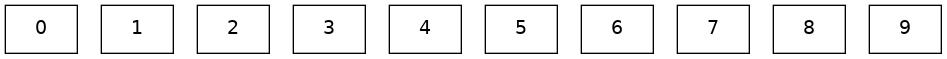

In [15]:
dvf_dd.visualize() # attention graphviz est requis

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

`graphviz` est requis pour ce graphique. S’il n’est pas installé dans votre environnement, faire :

``` python
!pip install graphviz
```

</div>

Pour construire de véritables *pipelines* de données,
les principes du [`pipe` de `pandas`](https://docs.dask.org/en/stable/generated/dask.dataframe.Series.pipe.html) évoqué [dans cette partie du cours](#pandas/#les-pipe) et celui des [pipelines scikit](https://ml.dask.org/compose.html), évoqué [dans un chapitre dédié](#pipeline-scikit/)
ont été importés dans `dask`.

## Problèmes de lecture dus à des types problématiques

La méthode `read_csv` de `dask` va inférer les types du `DataFrame` à partir d’échantillon, et va les implémenter sur tout le `DataFrame` seulement au moment d’une étape `compute`.

Il peut donc y avoir des erreurs de types dûs à un échantillon ne prenant pas en compte certains cas particuliers, causant des erreurs dans la lecture du fichier.

Dans ce cas, et comme de manière générale avec `pandas`, il peut être recommandé de faire appel au paramètre `dtype` de `read_csv` - qui est un `dict` - (la doc de `dask` nous dit aussi que l’on peut augmenter la taille de l’échantllon `sample`).

# Utiliser `dask` avec le format parquet

Le format `parquet` tend à devenir le format
de référence dans le monde de la *data-science*.
Une présentation extensive de celui-ci est disponible
dans le [chapitre dédié](#reads3).

`dask` permet de lire le format `parquet`, et plus précisément d’utiliser des fonctionnalités spécifiques à ce format. La lecture et l’écriture en `parquet` reposent par défaut sur `pyarrow`. On peut aussi utiliser `fastparquet` et préciser dans la lecture/écriture ce que l’on souhaite des deux.

In [16]:
dvf_net = dvf.loc[:,[ 'Date mutation', 'Nature mutation', 'Valeur fonciere', 'Commune', 
       'Code commune', 'Type local', 'Identifiant local', 'Surface reelle bati',
       'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain', 'year']]

On va utiliser l’*engine* par défaut pour
l’écriture de `parquet` qui est `pyarrow` (faire `pip install pyarrow` si vous ne l’avez pas déjà installé). `to_parquet` qui est une méthode `pandas` a été également étendue aux objets `dask`:

In [17]:
dvf_net.to_parquet("dvf/", partition_cols="year")

Lorsqu’il est partitionné, le format `parquet` amène à une structure
de fichiers similaire à [celle-ci](https://spark.apache.org/docs/latest/sql-data-sources-parquet.html#partition-discovery):

``` raw
path
└── to
    └── table
        ├── gender=male
        │   ├── ...
        │   │
        │   ├── country=US
        │   │   └── data.parquet
        │   ├── country=CN
        │   │   └── data.parquet
        │   └── ...
        └── gender=female
            ├── ...
            │
            ├── country=US
            │   └── data.parquet
            ├── country=CN
            │   └── data.parquet
            └── ...
```

On peut alors facilement traiter un sous-échantillon des données,
par exemple l’année 2019:

In [18]:
dvf_2019 = dd.read_parquet("dvf/year=2019/", columns=["Date mutation", "Valeur fonciere"]) # On peut sélectionner directement les deux colonnes

Lorsqu’il faudra passer à l’échelle, on changera le chemin en `"dvf/`
pour utiliser l’ensemble des données.

# A quoi sert `persist` ?

Par défaut, `compute` exécute l’ensemble du plan et ne conserve
en mémoire que le résultat de celui-ci. Les données intermédiaires
ne sont pas conservées. Si on désire réutiliser une partie de celui-ci,
par exemple les premières étapes, on devra donc ré-effectuer
les calculs.

Il est possible de garder une partie des données en mémoire avec `persist()`. Les données sont sauvegardées dans des objets appelés `Futures`. Cela peut être intéressant si un bloc particulier de données est utilisé dans plusieurs `compute` ou si l’on a besoin de voir ce qu’il y a à l’intérieur souvent.

In [19]:
dvf_dd_mem = dvf_dd.persist()

In [20]:
start_time = time.time()
dvf_dd_mem.head()
print(f"{time.time() - start_time} seconds")

In [21]:
start_time = time.time()
dvf_dd.head()
print(f"{time.time() - start_time} seconds")

0.002714395523071289 seconds

On a bien un temps plus important avec le `dask.DataFrame` initial, comparé avec celui sur lequel on a utilisé `persist`. L’opération qu’on réalise ici étant peu complexe, la différence n’est pas substantielle. Elle serait beaucoup plus marquée avec un jeu de données plus volumineux ou des étapes intensives en calcul.

# Aller plus loin: Utiliser le decorator `dask.delayed` pour paralléliser du code

Il est possible de paralléliser des fonctions par exemple en utilisant le **decorator** `dask.delayed`. Cela permet de rendre les fonctions `lazy`. Cela signifie que lorsqu’on appelle la fonction, un `delayed object` est construit. Pour avoir le résultat, il faut faire un `compute`. Pour aller plus loin: <https://tutorial.dask.org/03_dask.delayed.html>.

Prenons par exemple des fonctions permettant de calculer
des aires et des périmètres. Comme il s’agit d’une opération
très peu complexe, on ajoute un délai de calcul avec `time.sleep`
pour que le *timer* ne nous suggère pas que l’opération est
instantanée.

In [22]:
def aire_carre(longueur):
    time.sleep(1)
    return longueur**2

def perimetre_carre(longueur):
    time.sleep(1)
    return 4*longueur

def ajout_aire_perim(a, b):
    return a + b

Sans *timer*, c’est-à-dire de manière classique,
on ferait nos appels de fonctions de la
manière suivante:

In [23]:
start_time = time.time()
car1 = aire_carre(7)
car2 = perimetre_carre(9)
car3 = ajout_aire_perim(car1, car2)
car3
print(time.time() - start_time)

2.001600742340088

Avec le décorateur `dask.delayed`, on définit
nos fonctions de la manière suivante:

In [24]:
import dask

@dask.delayed
def aire_carre(longueur):
    time.sleep(1)
    return longueur**2

@dask.delayed
def perimetre_carre(longueur):
    time.sleep(1)
    return 4*longueur

@dask.delayed
def ajout_aire_perim(a, b):
    return a + b

L’appel de fonctions est identique

In [25]:
car1 = aire_carre(7)
car2 = perimetre_carre(9)
car3 = ajout_aire_perim(car1, car2)

Cependant, en fait rien n’a été calculé, si l’on souhaite le résultat, il faut appeler `compute`:

In [26]:
start_time = time.time()
car3.compute()
print(time.time() - start_time)

1.0024919509887695

Ici l’intérêt est assez limité, mais on voit que l’on réduit quand même de 2 à 1 seconde le temps de calcul. Mais l’idée derrière est que l’on a transformé `car3` en un objet `Delayed`. Cela a généré un `task graph` permettant de paralléliser certaines opérations.

Ici il est important de noter que les fonctions que l’on parallélise doivent mettre un certain temps, sinon il n’y aura pas de gain de performance (si on retire le `time.sleep` il n’y a pas de gain de performance car le fait de paralléliser rajoute en fait du temps vu que chaque fonction a un temps de calcul trop faible pour que la parallélisation soit intéressante).

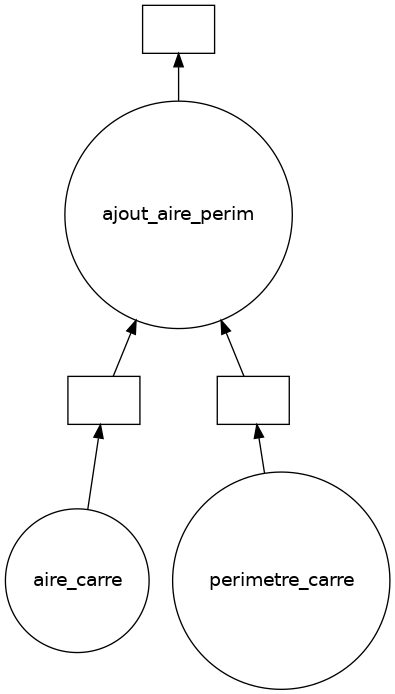

In [27]:
car3.visualize() # on peut visualiser le task graph et voir ce qui est fait en parallèle 

Il y a des exercices intéressants dans la doc de `Dask` sur les objets `Delayed`, notamment sur la parallélisation de séquence de traitement de données. Ils donnent l’exemple d’un ensemble de csv ayant le même format dont on veut résumer un indicateur final. On peut appliquer le decorator à une fonction permettant de lire le csv, puis utiliser une boucle `for` pour lire chaque fichier et appliquer les traitements. Ensuite, il faudra appeler `compute` sur l’objet final que l’on souhaite.

Pour aller plus loin sur l’utilisation de `Dask` sur un cluster voir <https://tutorial.dask.org/04_distributed.html>.

# Remerciements

Ce chapitre a été rédigé avec [Raphaële Adjerad](https://github.com/raphaeleadjerad).